# 共享单车用户画像分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn import metrics

sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1 - 数据概况分析

### 1.1 读取数据

In [2]:
mobike_raw = pd.read_csv('shared_bike.csv')
mobike_raw.drop(['Unnamed: 0'], axis=1, inplace=True)
mobike_raw.head()

,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
0,21499218,11/14/2018 7:37,11/14/2018 7:44,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37
1,21694389,12/18/2018 19:02,12/18/2018 19:10,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31
2,21110722,10/9/2018 12:37,10/9/2018 12:55,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30
3,21485409,11/12/2018 12:30,11/12/2018 12:40,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30
4,21445994,11/7/2018 7:29,11/7/2018 7:35,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40


### 1.2 数据概况

**数据字典**  
![dict](bike_dict.png)

In [3]:
mobike_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6427 entries, 0 to 6426
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            6427 non-null   int64  
 1   start_time         6427 non-null   object 
 2   end_time           6427 non-null   object 
 3   timeduration       6427 non-null   int64  
 4   bikeid             6427 non-null   int64  
 5   tripduration       6427 non-null   int64  
 6   from_station_id    6427 non-null   int64  
 7   from_station_name  6427 non-null   object 
 8   to_station_id      6427 non-null   int64  
 9   to_station_name    6427 non-null   object 
 10  usertype           6427 non-null   object 
 11  gender             5938 non-null   object 
 12  birthyear          5956 non-null   float64
 13  age                6427 non-null   object 
dtypes: float64(1), int64(6), object(7)
memory usage: 703.1+ KB


In [4]:
mobike_raw.describe()

,user_id,timeduration,bikeid,tripduration,from_station_id,to_station_id,birthyear
count,6.427000e+03,6427.000000,6427.000000,6.427000e+03,6427.000000,6427.000000,5956.000000
mean,2.135519e+07,11.778902,3491.637934,1.060471e+03,195.038432,198.502567,1982.488583
std,2.181294e+05,9.692236,1912.171846,1.456811e+04,148.170025,148.939873,11.147859
min,2.098358e+07,0.000000,2.000000,6.100000e+01,2.000000,2.000000,1906.000000
25%,2.116805e+07,5.000000,1852.000000,3.490000e+02,77.000000,80.000000,1977.000000
50%,2.135114e+07,9.000000,3618.000000,5.590000e+02,168.000000,172.000000,1986.000000
75%,2.154376e+07,15.000000,5179.500000,9.320000e+02,287.000000,287.000000,1991.000000
max,2.174223e+07,59.000000,6470.000000,1.139070e+06,662.000000,661.000000,2002.000000


## 2 - 数据预处理

In [5]:
mobike = mobike_raw.copy()

### 2.1 年龄

In [6]:
mobike['age'].unique()

array(['37', '31', '30', '40', '25', '48', ' ', '28', '27', '34', '33',
       '26', '20', '23', '55', '22', '54', '52', '57', '29', '39', '51',
       '32', '49', '43', '58', '42', '61', '35', '41', '63', '50', '38',
       '36', '44', '62', '19', '59', '45', '46', '56', '21', '24', '47',
       '66', '64', '77', '69', '60', '68', '70', '53', '113', '73', '18',
       '67', '65', '71', '79', '17', '101', '74', '72'], dtype=object)

In [7]:
# 发现年龄缺失值，查看行数
len(mobike[mobike['age']==' '])

471

In [8]:
# 空值行数量较少，去掉
mobike = mobike[mobike['age']!=' ']

In [9]:
# 将年龄的数据类型进行转换
mobike['age'] = pd.to_numeric(mobike['age'])
print(mobike['age'].dtype)

int64


In [10]:
# 保留年龄小于80的数据
mobike = mobike[mobike['age']<80]

### 2.2 性别

In [11]:
mobike['gender'].value_counts(dropna=False)

Male      4635
Female    1301
NaN         17
Name: gender, dtype: int64

In [12]:
mobike['gender'].value_counts(1, dropna=False)

Male      0.778599
Female    0.218545
NaN       0.002856
Name: gender, dtype: float64

In [13]:
# 仅有18个缺失值，删除
mobike.dropna(subset=['gender'], inplace=True)

### 2.3 骑行时间

#### 2.3.1 转化数据类型

In [14]:
# 转化时间类型数据
mobike['start_time'] = pd.to_datetime(mobike['start_time'])
mobike['end_time'] = pd.to_datetime(mobike['end_time'])

#### 2.3.2 创建计算字段

In [15]:
# 是否为工作日
mobike['is_weekday'] = mobike['start_time'].dt.dayofweek.apply(lambda x: 0 if x in [5, 6] else 1)

In [16]:
# 是否是早晚高峰
mobike['is_morning_rush'] = mobike['start_time'].dt.hour.apply(lambda x: 1 if x in [6, 7, 8] else 0)
mobike['is_evening_rush'] = mobike['start_time'].dt.hour.apply(lambda x: 1 if x in [16, 17, 18] else 0)

### 2.5 骑行时长

#### 2.5.1 检查骑行时长异常数据

In [17]:
mb = mobike.copy()
mb = mb[['start_time', 'end_time', 'timeduration', 'tripduration']]
mb['time_diff'] = ((mb['end_time'] - mb['start_time']).dt.seconds/60).astype(int) # 创建计算字段

mb.head()

,start_time,end_time,timeduration,tripduration,time_diff
0,2018-11-14 07:37:00,2018-11-14 07:44:00,7,436,7
1,2018-12-18 19:02:00,2018-12-18 19:10:00,7,445,8
2,2018-10-09 12:37:00,2018-10-09 12:55:00,18,1090,18
3,2018-11-12 12:30:00,2018-11-12 12:40:00,9,581,10
4,2018-11-07 07:29:00,2018-11-07 07:35:00,6,390,6


In [18]:
# 检查异常数据
mb_time_error = mb[~((mb['timeduration'] == mb['time_diff']) | (mb['timeduration'] ==(mb['time_diff']-1)))]
print(mb_time_error.shape)
mb_time_error.head()

(53, 5)


,start_time,end_time,timeduration,tripduration,time_diff
14,2018-10-10 17:42:00,2018-10-10 23:37:00,55,21307,355
117,2018-10-15 14:15:00,2018-10-15 17:21:00,5,11158,186
258,2018-10-07 12:35:00,2018-10-07 15:29:00,53,10419,174
271,2018-12-19 23:05:00,2018-12-22 16:01:00,55,233732,1016
484,2018-11-13 13:38:00,2018-11-13 15:41:00,3,7405,123


存在 timeduration 计算错误的数据，同时 tripduration 也很长

In [19]:
# 去掉异常数据
mobike.drop(index=mb_time_error.index, inplace=True)

#### 2.5.2 重新计算时长

In [20]:
# 重新计算骑行时长
mobike['timeduration'] = ((mobike['end_time'] - mobike['start_time']).dt.seconds/60).astype(int)

### 2.6 平均骑行速度

In [21]:
mb = mobike.copy()
mb = mb[['start_time', 'end_time', 'timeduration', 'tripduration']]
mb['speed'] = mb['tripduration']/mb['timeduration']
mb.head()

,start_time,end_time,timeduration,tripduration,speed
0,2018-11-14 07:37:00,2018-11-14 07:44:00,7,436,62.285714
1,2018-12-18 19:02:00,2018-12-18 19:10:00,8,445,55.625000
2,2018-10-09 12:37:00,2018-10-09 12:55:00,18,1090,60.555556
3,2018-11-12 12:30:00,2018-11-12 12:40:00,10,581,58.100000
4,2018-11-07 07:29:00,2018-11-07 07:35:00,6,390,65.000000


## 3 - 探索性分析 (EDA)

### 3.1 年龄

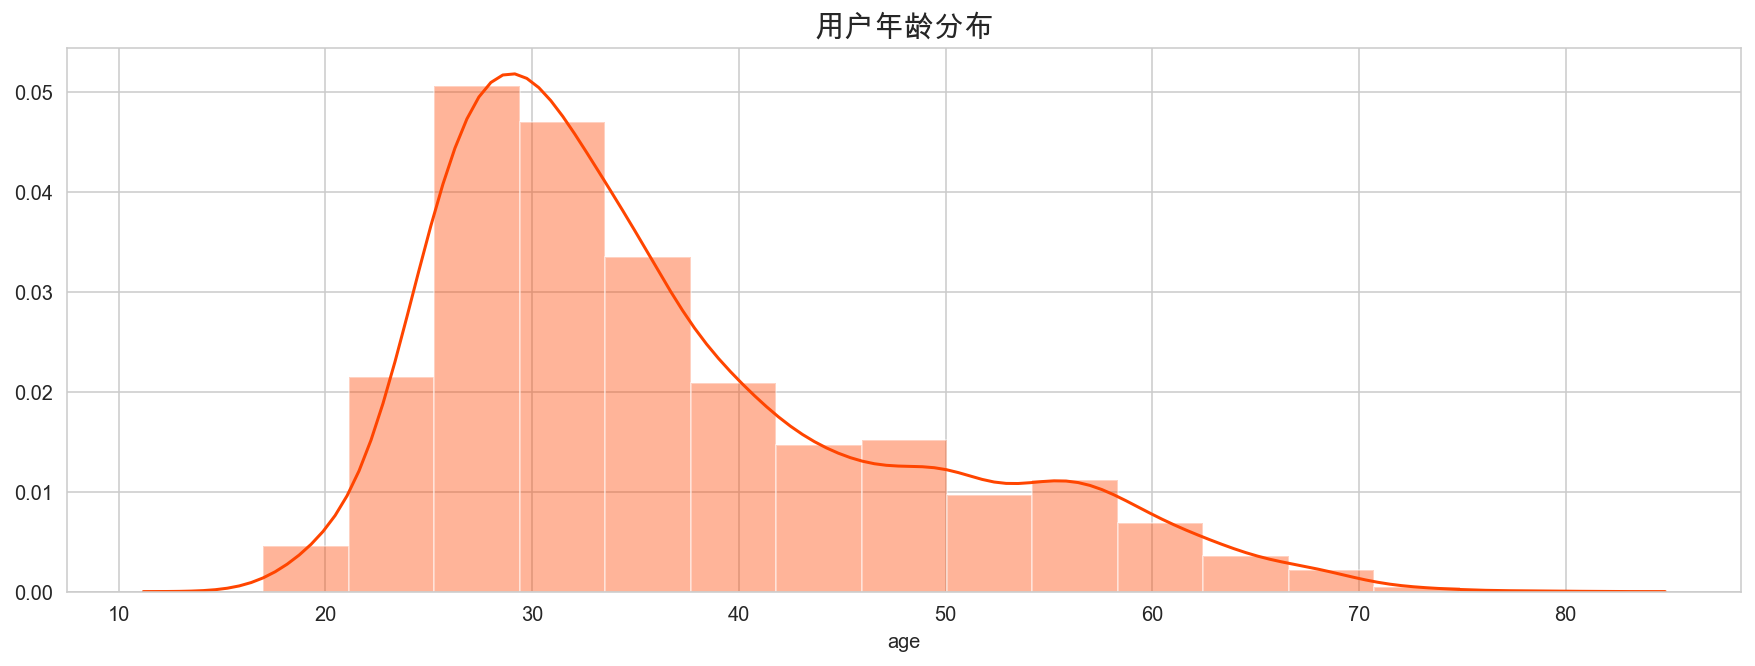

In [22]:
plt.figure(figsize=(15,5))

sns.distplot(mobike['age'], bins=15, color='orangered')
plt.title("用户年龄分布", fontsize=15)

plt.show()

大部分用户集中在 25-35 年龄段

### 3.2 性别

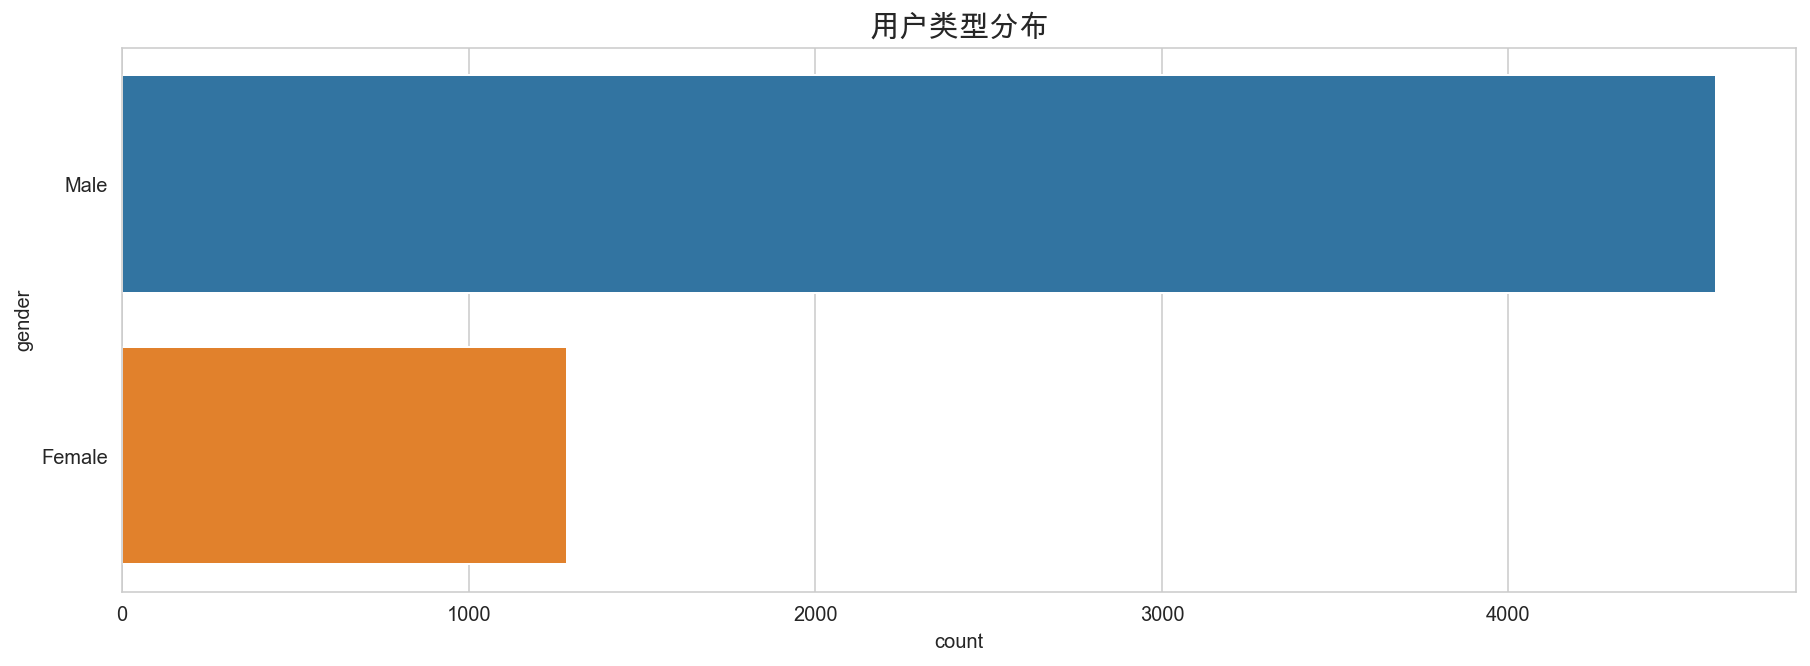

In [23]:
plt.figure(figsize=(15,5))

sns.countplot(y='gender', data=mobike)
plt.title("用户类型分布", fontsize=15)

plt.show()

男性用户较多，约占 78%

### 3.3 用户类型

In [24]:
mobike['usertype'].value_counts()

Subscriber    5704
Customer       179
Name: usertype, dtype: int64

In [25]:
mobike['usertype'].value_counts(1)

Subscriber    0.969573
Customer      0.030427
Name: usertype, dtype: float64

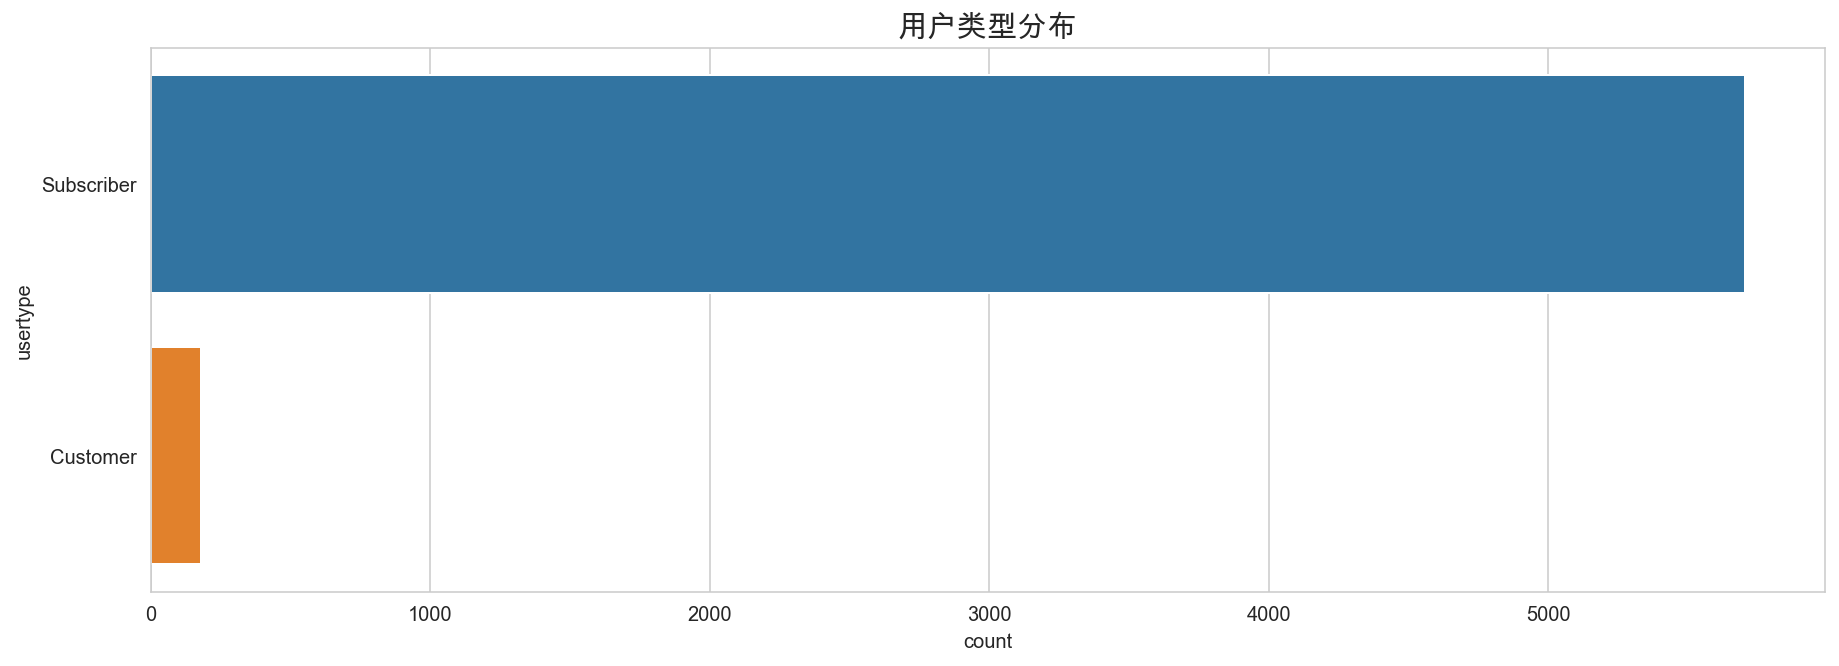

In [26]:
plt.figure(figsize=(15,5))

sns.countplot(y='usertype', data=mobike)
plt.title("用户类型分布", fontsize=15)

plt.show()

大部分为订阅用户，占 96.5%

### 3.4 骑行时间

In [27]:
# 查看骑行时间年的分布
mobike['start_time'].dt.year.value_counts()

2018    5883
Name: start_time, dtype: int64

In [28]:
# 查看骑行时间月份的分布
mobike['start_time'].dt.month.value_counts()

10    3107
11    1601
12    1175
Name: start_time, dtype: int64

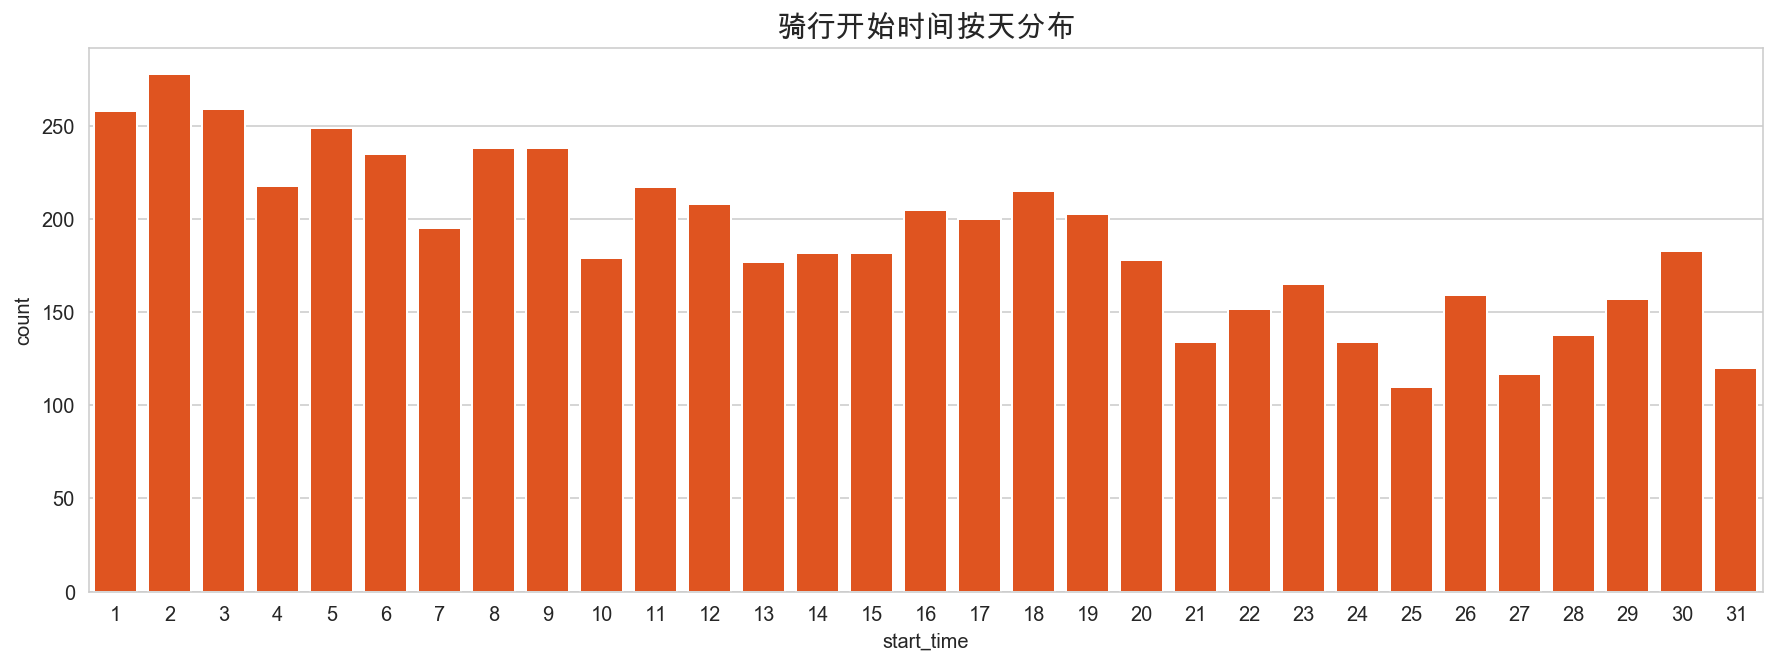

In [29]:
# 查看骑行时间按天分布
plt.figure(figsize=(15,5))

sns.countplot(mobike['start_time'].dt.day, color='orangered')
plt.title("骑行开始时间按天分布", fontsize=15)

plt.show()

在月末骑行的人略少于月初和月中的人

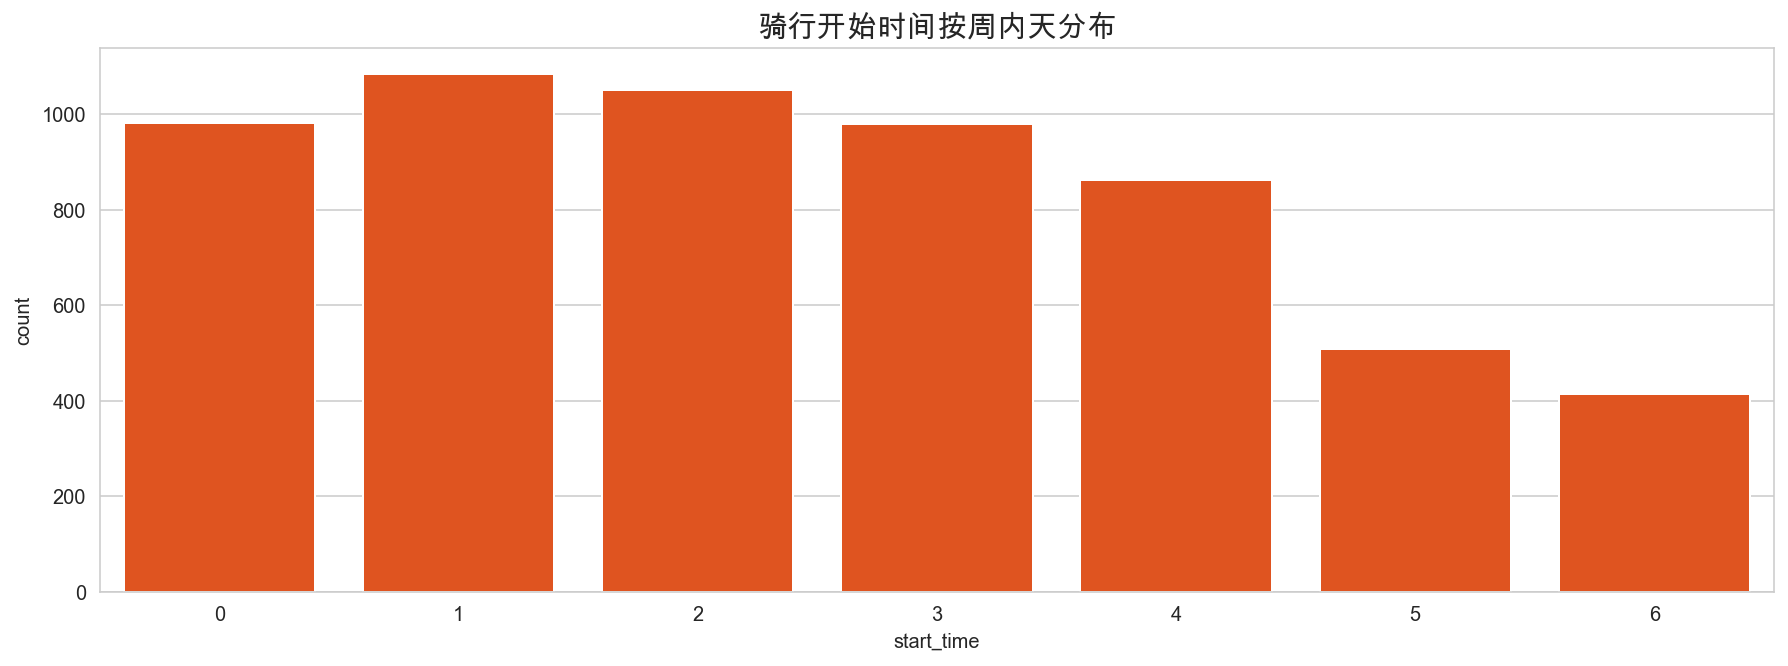

In [30]:
# 查看骑行时间按周内天分布
plt.figure(figsize=(15,5))

sns.countplot(mobike['start_time'].dt.dayofweek, color='orangered')
plt.title("骑行开始时间按周内天分布", fontsize=15)

plt.show()

周末骑行的人少于周中的

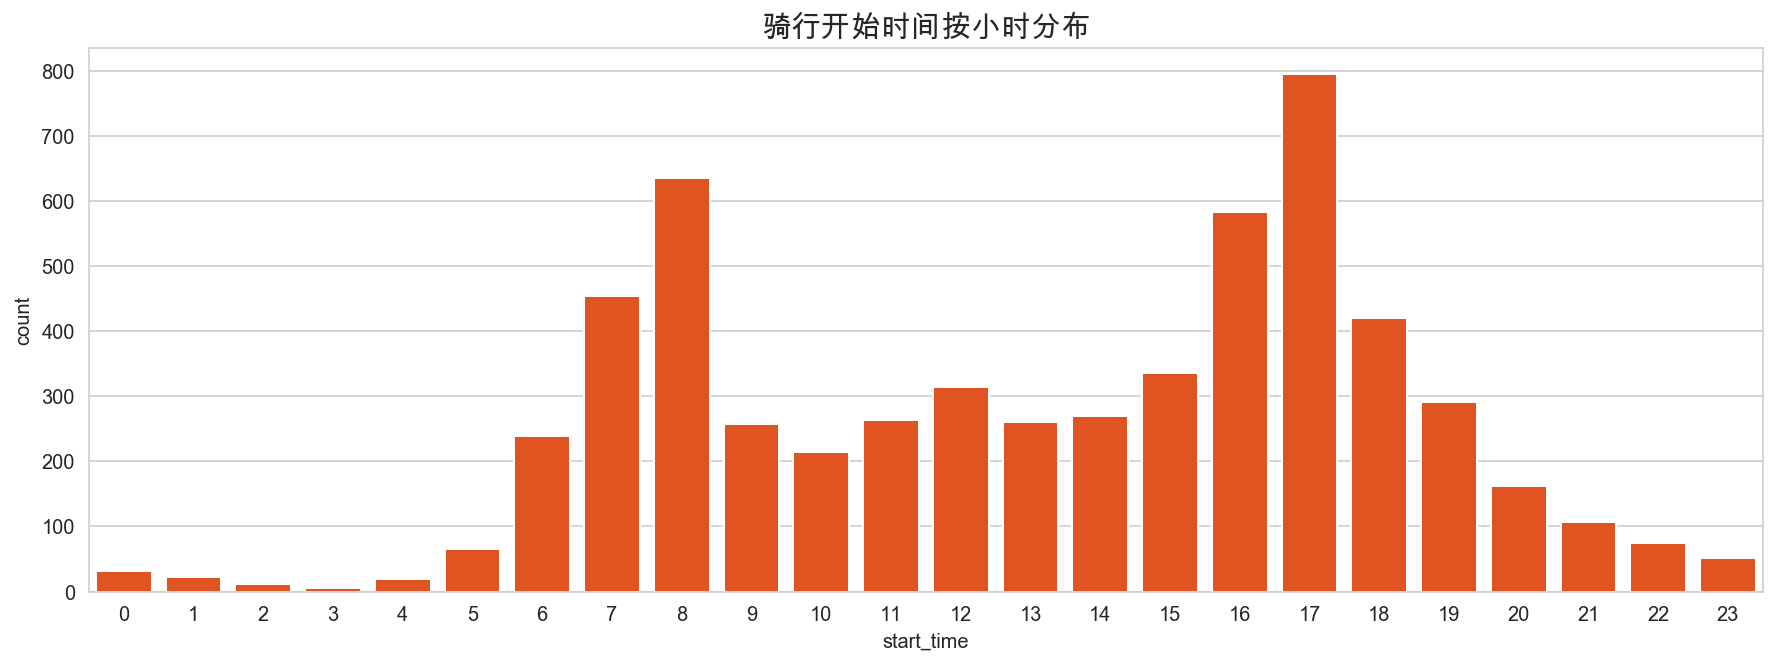

In [31]:
# 查看骑行开始时间按小时分布
plt.figure(figsize=(15,5))

sns.countplot(mobike['start_time'].dt.hour, color='orangered')
plt.title("骑行开始时间按小时分布", fontsize=15)

plt.show()

早晚高峰的骑车数量明显增多

### 3.5 骑行时长

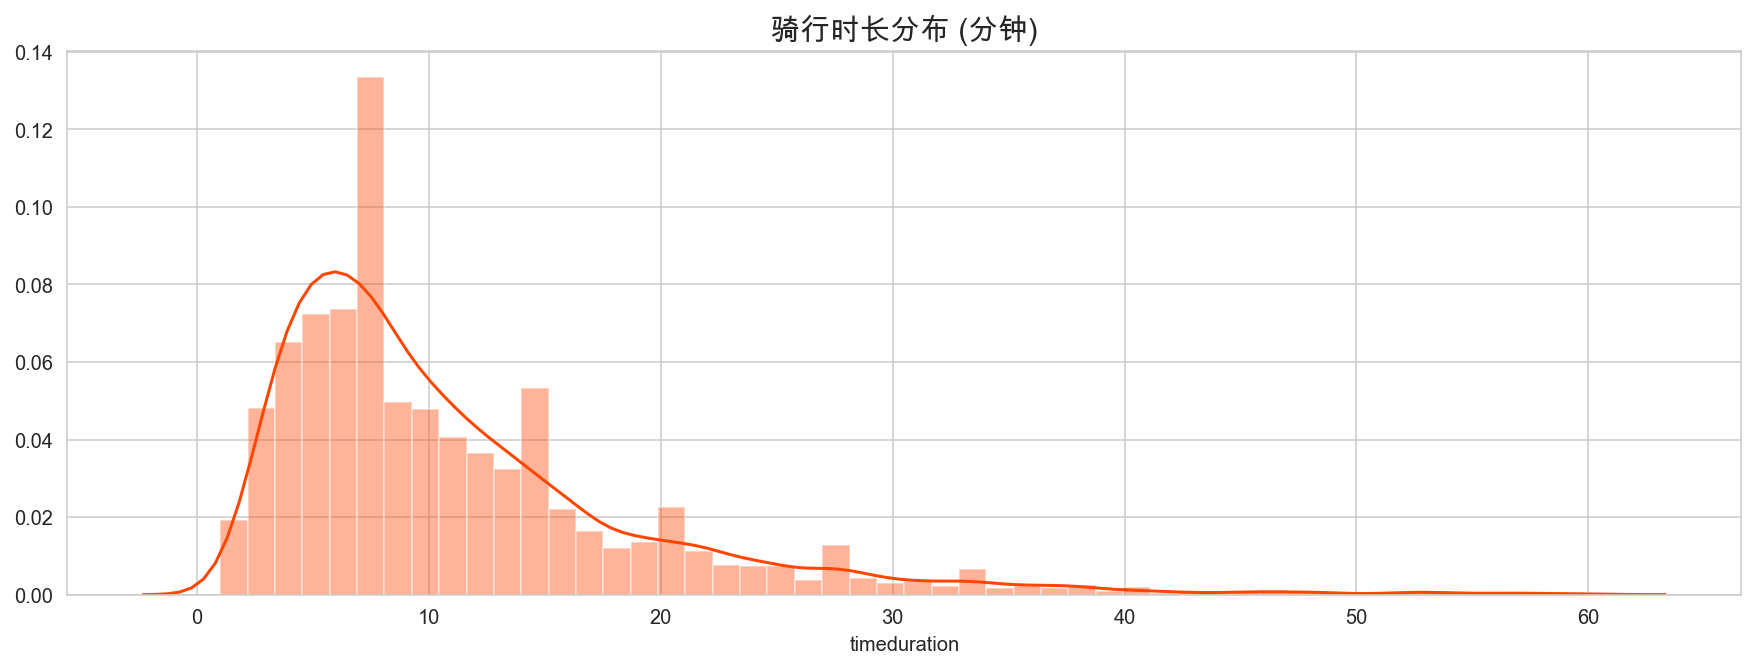

In [32]:
plt.figure(figsize=(15,5))

sns.distplot(mobike['timeduration'], color='orangered')
plt.title("骑行时长分布 (分钟)", fontsize=15)

plt.show()

骑行时长在 5-15 分钟最多

### 3.6 骑行距离

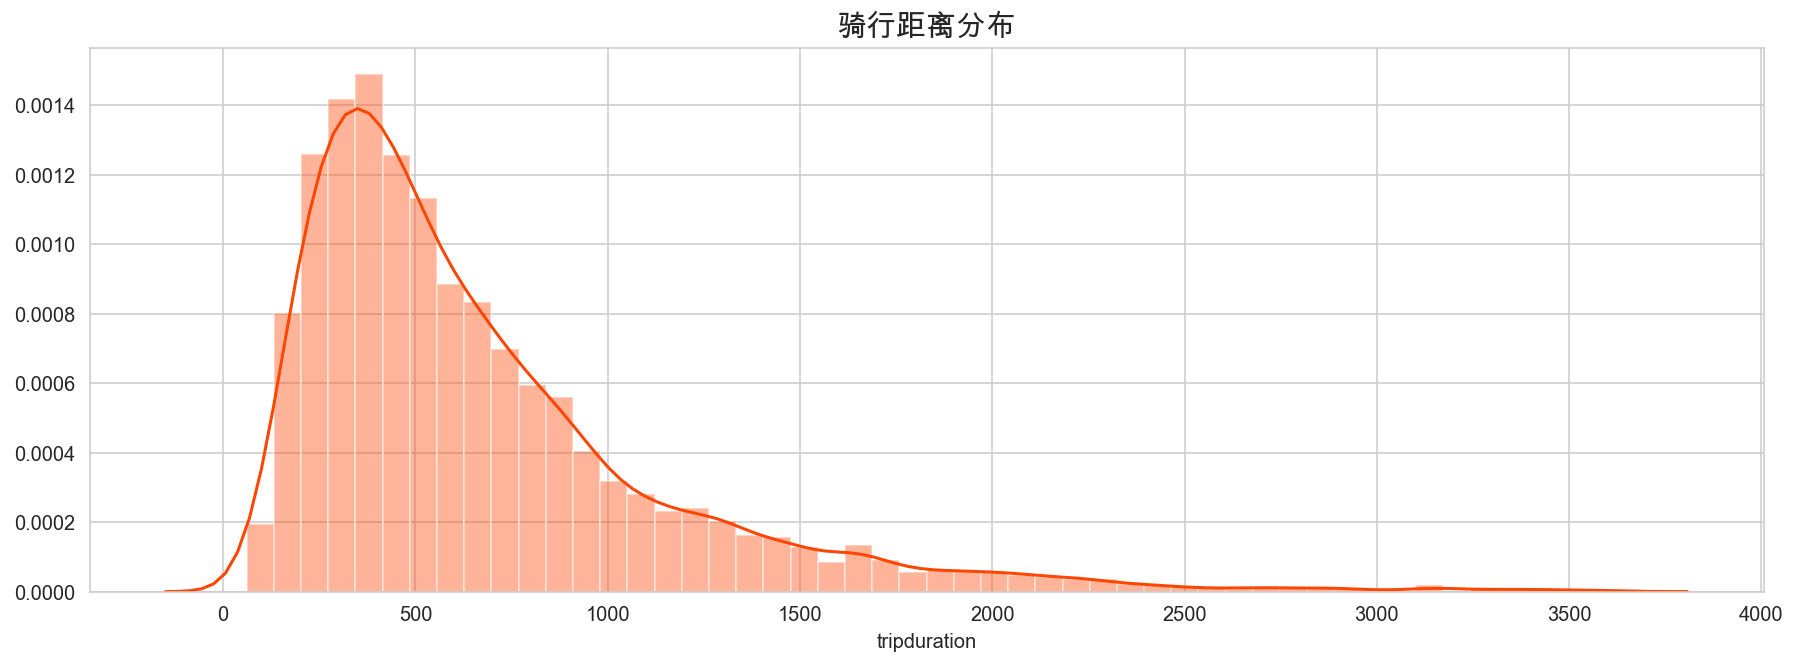

In [33]:
plt.figure(figsize=(15,5))

sns.distplot(mobike['tripduration'], color='orangered')
plt.title("骑行距离分布", fontsize=15)

plt.show()

骑行距离在 200-800 米最多

### 3.7 平均骑行速度

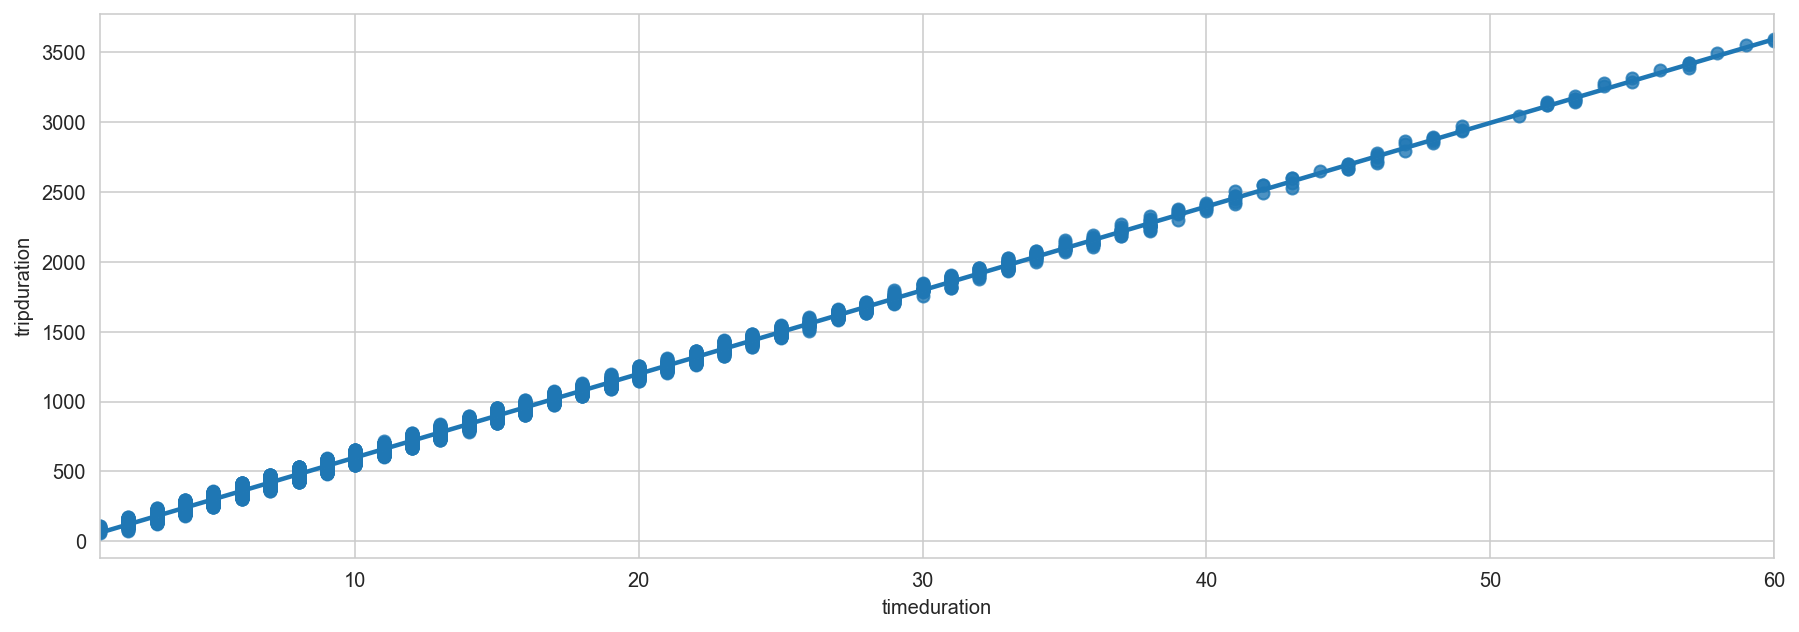

In [34]:
plt.figure(figsize=(15,5))
sns.regplot(mobike['timeduration'], mobike['tripduration'])

plt.show()

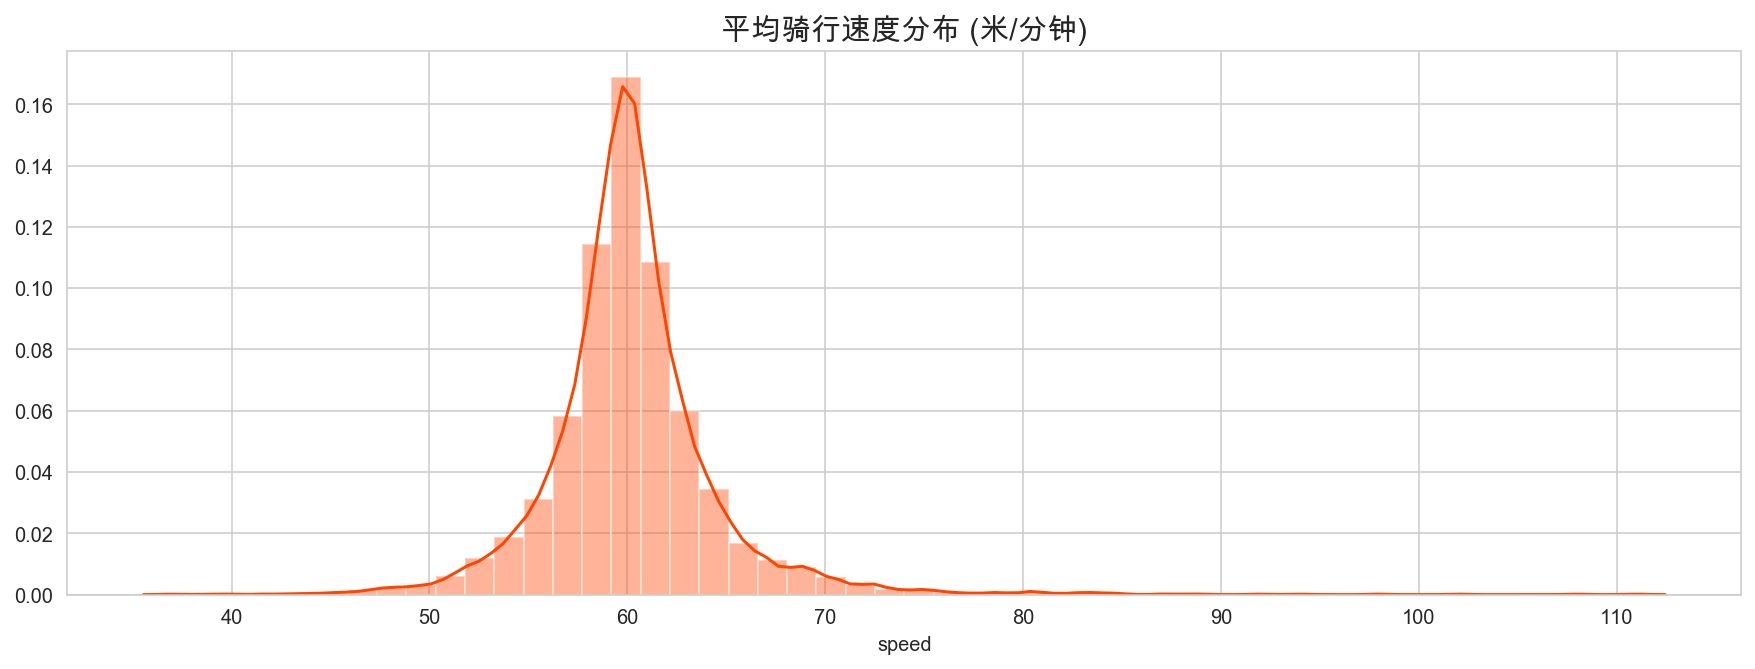

In [35]:
plt.figure(figsize=(15,5))

sns.distplot(mb['speed'], color='orangered')
plt.title("平均骑行速度分布 (米/分钟)", fontsize=15)

plt.show()

平均骑行速度集中在 60米/分钟 左右

## 4 - 聚类分析

### 4.1 - 数据准备

In [36]:
mobike_cluster = mobike[['age', 'gender', 'usertype', 'tripduration', 'timeduration',
                         'is_weekday', 'is_morning_rush', 'is_evening_rush']].copy()

In [37]:
# 转化类别变量
mobike_cluster = pd.get_dummies(mobike_cluster)
mobike_cluster.drop(['gender_Female', 'usertype_Customer'], axis=1, inplace=True)

In [38]:
mobike_cluster.head()

,age,tripduration,timeduration,is_weekday,is_morning_rush,is_evening_rush,gender_Male,usertype_Subscriber
0,37,436,7,1,1,0,1,1
1,31,445,8,1,0,0,1,1
2,30,1090,18,1,0,0,1,0
3,30,581,10,1,0,0,0,1
4,40,390,6,1,1,0,1,1


In [39]:
mobike_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5883 entries, 0 to 6426
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  5883 non-null   int64
 1   tripduration         5883 non-null   int64
 2   timeduration         5883 non-null   int64
 3   is_weekday           5883 non-null   int64
 4   is_morning_rush      5883 non-null   int64
 5   is_evening_rush      5883 non-null   int64
 6   gender_Male          5883 non-null   uint8
 7   usertype_Subscriber  5883 non-null   uint8
dtypes: int64(6), uint8(2)
memory usage: 493.2 KB


In [40]:
# 标准化处理
X = pd.DataFrame(scale(mobike_cluster))

### 4.2 - K-Means 聚类模型

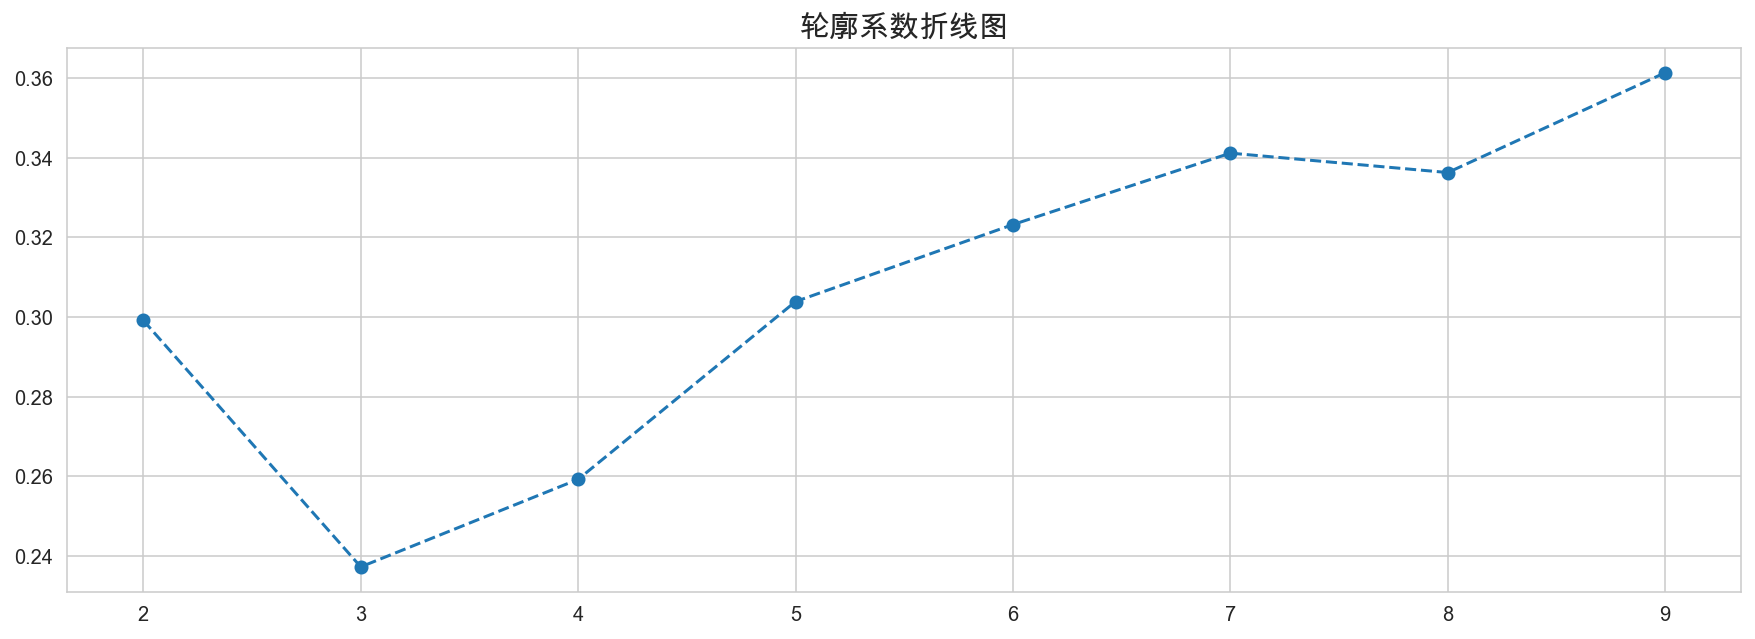

In [41]:
# 寻找最优 k

def KM_score(X, k: int) -> float:
    """返回轮廓系数 (Silhouette score)"""
    model=KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    X_cluster = model.fit_predict(X)
    score = metrics.silhouette_score(X, X_cluster)
    
    return score

# 计算轮廓系数
score_dict = {}
for i in range(2, 10):
    score_dict[i] = KM_score(X, i)

# 绘制轮廓系数图像
plt.figure(figsize=(15,5))
plt.plot(score_dict.keys(), score_dict.values(), linestyle='--', marker='o')
plt.title("轮廓系数折线图", fontsize=15)
plt.show()

In [42]:
# 为了观察分群效果，我们选择分成7组
model = KMeans(n_clusters=7, random_state=42)
model.fit(X)

KMeans(n_clusters=7, random_state=42)

In [43]:
mobike_cluster['cluster'] = model.labels_

In [44]:
mobike_cluster['cluster'].value_counts()

0    1399
2    1167
6    1114
3     783
1     703
5     538
4     179
Name: cluster, dtype: int64

### 4.3 查看聚类效果

In [45]:
mobike_cluster.groupby(['cluster'])['timeduration'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1399.0,7.975697,4.156039,1.0,5.0,7.0,11.0,19.0
1,703.0,9.615932,4.931771,1.0,6.0,9.0,13.0,23.0
2,1167.0,9.262211,4.824872,1.0,6.0,8.0,12.0,23.0
3,783.0,9.286079,5.265814,1.0,5.0,8.0,13.0,25.0
4,179.0,20.016760,13.295042,4.0,9.0,16.0,28.0,60.0
5,538.0,29.171004,7.677662,19.0,24.0,27.0,33.0,60.0
6,1114.0,9.270197,4.610593,1.0,6.0,8.0,12.0,21.0


In [46]:
mobike_cluster.groupby(['cluster'])['tripduration'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1399.0,478.370979,248.344145,74.0,289.00,420.0,635.00,1191.0
1,703.0,578.083926,296.624495,67.0,348.00,527.0,762.50,1377.0
2,1167.0,555.832905,288.001391,61.0,334.50,500.0,734.00,1394.0
3,783.0,557.503193,315.455506,78.0,307.00,479.0,749.50,1477.0
4,179.0,1201.486034,798.199824,236.0,529.50,980.0,1667.50,3597.0
5,538.0,1748.819703,461.001346,1147.0,1431.00,1632.5,1959.75,3583.0
6,1114.0,555.160682,276.301969,80.0,338.25,495.0,735.50,1279.0


4，5 组骑行时间较长，骑行距离也远

## 5 - 聚类业务解读

In [47]:
pd.DataFrame(model.cluster_centers_, columns=mobike_cluster.columns[:8])

,age,tripduration,timeduration,is_weekday,is_morning_rush,is_evening_rush,gender_Male,usertype_Subscriber
0,0.025921,-0.389358,-0.388915,0.431380,-0.539952,-0.663436,0.528122,0.177148
1,-0.120706,-0.185599,-0.188024,0.431380,-0.539952,0.293790,-1.893501,0.177148
2,0.120397,-0.231068,-0.231347,0.431380,1.852018,-0.663436,0.073679,0.177148
3,-0.119025,-0.227655,-0.228424,-2.318142,-0.374988,-0.283625,-0.096613,0.177148
4,-0.303153,1.088299,1.085837,-0.520968,-0.312781,-0.020702,-0.067137,-5.644991
5,0.079812,2.206753,2.207020,0.032750,-0.139808,0.078974,0.010489,0.177148
6,0.011321,-0.232442,-0.230369,0.431380,-0.539952,1.507305,0.528122,0.177148


**聚类分组分析**  
- 4， 5 组的骑行时间和距离较大
- 3 组主要在周末骑行
- 2 组主要是早高峰骑行的用户
- 6 组主要是晚高峰用户
- 1 组女性用户较多
- 4 组主要是非订阅用户

**总结**  
- 通过用户基本数据分析，我们的大部分用户为25-35的年轻人，在工作日的早晚高峰进行短距离骑行，我们可针对此类人气进行精准营销，进行推送和优惠券的发放来提高业务收入
- 通过聚类分析，我们可以得到各组用户的特征从而给他们打上标签，例如‘晚高峰用户’，之后可在晚高峰前给予信息推送，从而提高单车的使用率